In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [5]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100
MIN_SIZE = 0
NUM_CORES = 22

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [7]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
TEST_MATRIX = "test_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

In [8]:
root_location = "/big/s/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"
test_preprocessed_files_prefix = preprocessed_location + "test_docs_merged_data_preprocessed-"
test_preprocessed_docids_files_prefix = preprocessed_location + "test_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [9]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 28.4 s, sys: 896 ms, total: 29.3 s
Wall time: 29.4 s


In [10]:
len(training_docs_list)

1286325

In [11]:
len(validation_docs_list)

321473

In [12]:
len(test_docs_list)

401877

In [13]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [36]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, file_to_write, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write)))
        for validation_doc_id in val_docs_list:
            val_labels = set(doc_classification_map[validation_doc_id]) & classifications_set
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels, dtype=np.int8)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = set(doc_classification_map[validation_doc_id]) & classifications_set
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors, dtype=np.int8)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [16]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    training_data = []
    training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
    for i,doc_id in enumerate(training_docs_list):
        normal_array = doc2vec_model.docvecs[doc_id]
        training_data.append(normal_array)
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        if i % 100000 == 0:
            info("Finished {} in training".format(i))
    info("doing matrix creation")
    training_data_mat = np.array(training_data)
    del training_data
    return training_data_mat, training_labels_mat

In [17]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        del self.curr_lines, self.curr_docids
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

### Doc2vec and SVM Parameters

In [48]:
DOC2VEC_SIZE = 60
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 10000 # report vocab progress every x documents

In [49]:
SVM_ITERATIONS = 10
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = 'balanced'
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

## Create the Doc2vec model

In [50]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_60_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [51]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [52]:
%%time
training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-03-04 16:34:30,071 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model
2017-03-04 16:34:45,373 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.docvecs.* with mmap=None
2017-03-04 16:34:45,375 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.docvecs.doctag_syn0.npy with mmap=None
2017-03-04 16:34:47,658 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.syn1neg.npy with mmap=None
2017-03-04 16:35:05,798 : INFO : loading syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.syn0.npy with mmap=None
2017-03-04 16:35:06,786 : INFO : setting ignored attribute syn0norm to None
2017-03-04 16:35:06,787 : INFO : setting ignored attribute cum_table to None
2017-03-04 16:35:09,272 : INFO : resetting layer weights


CPU times: user 59.5 s, sys: 14 s, total: 1min 13s
Wall time: 1min 24s


In [53]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [54]:
doc2vec_model.min_alpha = 0.025
DOC2VEC_ALPHA_DECREASE = 0.001
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'
classifier_file = TYPE_CLASSIFIER.format(classifications_type)

In [55]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

<IPython.core.display.Javascript object>


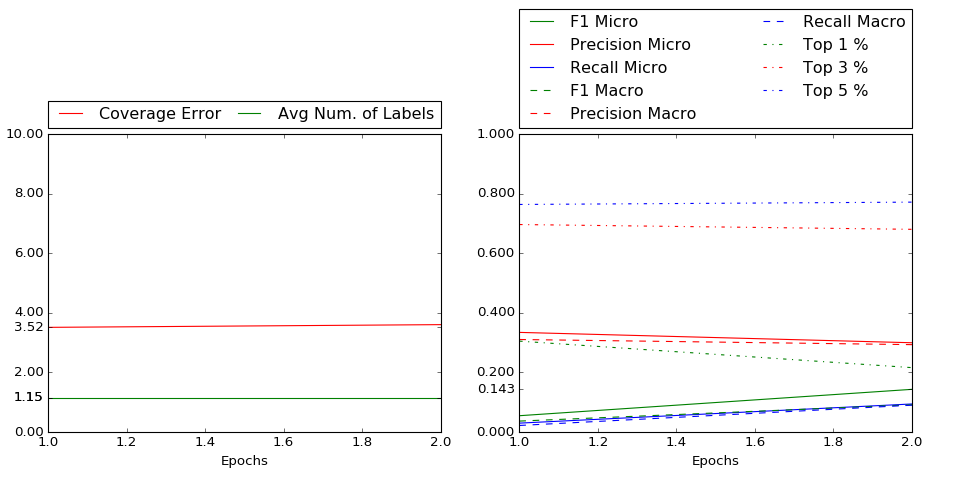

2017-03-04 16:35:54,599 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_60_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-03-04 16:35:54,601 : INFO : training model with 22 workers on 391521 vocabulary and 60 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-04 16:35:54,602 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-03-04 16:35:54,612 : INFO : Loading new batch for index: 0
2017-03-04 16:36:05,358 : INFO : Finished loading new batch
2017-03-04 16:36:05,794 : INFO : PROGRESS: at 0.00% examples, 306 words/s, in_qsize 44, out_qsize 1
2017-03-04 16:36:25,800 : INFO : PROGRESS: at 0.28% examples, 639471 words/s, in_qsize 43, out_qsize 0
2017-03-04 16:36:45,818 : INFO : PROGRESS: at 0.58% examples, 774846 words/s, in_qsize 43, out_qsize 2
2017-03-04 16:37:02,651 : INFO : Loading new batch for index: 10000
2017-03-04 16:37:13,546 : INFO : Finished loading new ba

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.516, Avg Labels: 1.150, 
		 Top 1: 0.305, Top 3: 0.697, Top 5: 0.765, 
		 F1 Micro: 0.055, F1 Macro: 0.037, Total Pos: 32,859


2017-03-04 21:39:40,150 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_60_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-03-04 21:39:40,151 : INFO : training model with 22 workers on 391521 vocabulary and 60 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-04 21:39:40,152 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-03-04 21:39:40,170 : INFO : Loading new batch for index: 0
2017-03-04 21:39:52,293 : INFO : Finished loading new batch
2017-03-04 21:39:53,429 : INFO : PROGRESS: at 0.00% examples, 304 words/s, in_qsize 1, out_qsize 1
2017-03-04 21:40:13,402 : INFO : PROGRESS: at 0.23% examples, 503383 words/s, in_qsize 44, out_qsize 0
2017-03-04 21:40:33,406 : INFO : PROGRESS: at 0.49% examples, 635970 words/s, in_qsize 43, out_qsize 1
2017-03-04 21:40:53,425 : INFO : PROGRESS: at 0.74% examples, 694627 words/s, in_qsize 43, out_qsize 1
2017-03-04 21:40:59,78

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.608, Avg Labels: 1.150, 
		 Top 1: 0.216, Top 3: 0.681, Top 5: 0.772, 
		 F1 Micro: 0.143, F1 Macro: 0.092, Total Pos: 115,972


2017-03-05 03:02:13,207 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_60_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-03-05 03:02:13,209 : INFO : training model with 22 workers on 391521 vocabulary and 60 features, using sg=0 hs=0 sample=0.001 negative=10
2017-03-05 03:02:13,210 : INFO : expecting 1651226 sentences, matching count from corpus used for vocabulary survey
2017-03-05 03:02:13,221 : INFO : Loading new batch for index: 0
2017-03-05 03:02:25,805 : INFO : Finished loading new batch
2017-03-05 03:02:27,322 : INFO : PROGRESS: at 0.00% examples, 287 words/s, in_qsize 16, out_qsize 0


In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        doc2vec_model.workers = NUM_CORES
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= DOC2VEC_ALPHA_DECREASE  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))

    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, classifier_file)):

        info('Getting training Data')
        X, y = get_training_data(doc2vec_model, classifications)
        
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, classifier_file), 'w'))
        
    #     # Training Metrics
    #     info('Evaluating on Training Data')
    #     yp = clf.predict(X)
    #     yp_score = clf.decision_function(X)
    #     print yp
    #     training_metrics = get_metrics(y, yp_score, yp)
    #     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    #         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    #         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    #         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])

    #     epoch_training_metrics.append(training_metrics)

        del X, y

    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, classifier_file), 'r'))
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, VALIDATION_MATRIX, 
                                                    validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp_score, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


In [29]:
ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-07 08:11:41,882 : INFO : saving Doc2Vec object under /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model, separately None
2017-01-07 08:11:41,883 : INFO : storing numpy array 'doctag_syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.docvecs.doctag_syn0.npy
2017-01-07 08:12:17,445 : INFO : storing numpy array 'syn1neg' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn1neg.npy
2017-01-07 08:12:32,559 : INFO : not storing attribute syn0norm
2017-01-07 08:12:32,560 : INFO : storing numpy array 'syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_No

In [75]:
from multiprocessing.dummy import Pool as ThreadPool 

In [43]:
import thesis.utils.metrics

In [84]:
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
i=0
doc_contents = []
for (doc_id, doc_contents_array) in validation_docs_iterator:
    i += 1
    doc_contents.append((doc_id, doc_contents_array))
    if i > 100:
        break

2016-12-28 22:22:21,536 : INFO : Loading new batch
2016-12-28 22:22:27,109 : INFO : Finished loading new batch


In [133]:
def infer_one_doc(doc):
    #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
    rep = doc2vec_model.infer_vector(doc[1])
    return (doc[0], rep)

Threaded Version

In [114]:
%%time
pool = ThreadPool(16)
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
threaded_reps = pool.map(infer_one_doc, doc_contents)


CPU times: user 1min 41s, sys: 620 ms, total: 1min 41s
Wall time: 9.83 s


Non-Threaded Version

In [112]:
%%time
reps = []
doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
for doc in doc_contents:
    reps.append((doc[0], doc2vec_model.infer_vector(doc[1])))

CPU times: user 14 s, sys: 44 ms, total: 14.1 s
Wall time: 13.9 s


In [100]:
np.array_equal([d[0] for d in reps], [d[0] for d in threaded_reps])

True

Simple threading, but problem is that pool.map exhausts the whole iterable

In [120]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(16)
threaded_reps = pool.map(infer_one_doc, validation_docs_iterator)

2016-12-28 23:52:07,981 : INFO : Loading new batch for index: 0


CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 26.4 ms


2016-12-28 23:52:14,764 : INFO : Finished loading new batch
2016-12-28 23:52:16,320 : INFO : Loading new batch for index: 10000
2016-12-28 23:52:36,742 : INFO : Finished loading new batch
2016-12-28 23:52:37,438 : INFO : Loading new batch for index: 12412
2016-12-28 23:52:37,487 : INFO : No more batches to load, exiting at index: 12412


More advanced threading

In [140]:
def nothing_func(doc):
    1 + 1

In [ ]:
%%time
validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                  validation_preprocessed_docids_files_prefix, batch_size=None)
pool = ThreadPool(20)
# map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
threaded_reps = []
mini_batch_size = 1000
while True:
    threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(validation_docs_iterator, mini_batch_size))
    info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
    if threaded_reps_partial:
        threaded_reps.extend(threaded_reps_partial)
    else:
        break

In [196]:
X, y = get_training_data(doc2vec_model, classifications)

In [202]:
yc = np.array(y)

In [203]:
yc.shape

(49789, 8)

In [ ]:
from sklearn.svm import SVC

In [173]:
import numpy as np
from sklearn import linear_model
X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
Y = np.array(['a', 'a', 'b', 'b'])
clf = linear_model.SGDClassifier()
clf.fit(X, Y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [ ]:
clf.predict([[-0.8, -1]])

In [26]:
best_svm_epoch = 13

In [29]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(best_svm_epoch)
doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2016-11-26 18:25:14,192 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model
2016-11-26 18:25:14,584 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.* with mmap=None
2016-11-26 18:25:14,585 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.docvecs.doctag_syn0.npy with mmap=None
2016-11-26 18:25:14,814 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_13/model.syn1neg.npy with mmap

#### Prepare Training Data

In [31]:
%%time
classifications = sections

NN_OUTPUT_NEURONS = len(classifications)
one_hot_encoder = OneHotEncoder(classifications)
training_data = []
training_labels = []
for doc_id in training_docs_list:
    # converting from memmap to a normal array
    normal_array = []
    normal_array[:] = doc2vec_model.docvecs[doc_id][:]
    training_data.append(normal_array)
    eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
    training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

CPU times: user 1.61 s, sys: 520 ms, total: 2.13 s
Wall time: 1.93 s


#### Prepare Validation Data

In [32]:
%%time

validation_labels = []
validation_data = pickle.load(open(
        os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)
))
print validation_data.shape

for validation_doc_id in validation_docs_list:
    eligible_classifications = [clssf for clssf in doc_classification_map[validation_doc_id] if clssf in classifications]
    validation_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))

(1969, 3000)
CPU times: user 2.58 s, sys: 360 ms, total: 2.94 s
Wall time: 2.93 s


In [186]:
pickle.dump(history_list, open('/mnt/data2/shalaby/history_list_sample_0.0001.pickle','w'))

In [181]:
print len(history_list)

100


In [147]:
doc_input = Input(shape=(DOC2VEC_SIZE,), name='doc_input')
hidden = Dense(NN_HIDDEN_NEURONS, activation='relu', name='hidden_layer')(doc_input)
softmax_output = Dense(NN_OUTPUT_NEURONS, activation='sigmoid', name='softmax_output')(hidden)
model = Model(input=doc_input, output=softmax_output)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', 'fbeta_score', theano_coverage_error])

In [148]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
doc_input (InputLayer)           (None, 3000)          0                                            
____________________________________________________________________________________________________
hidden_layer (Dense)             (None, 4500)          13504500    doc_input[0][0]                  
____________________________________________________________________________________________________
softmax_output (Dense)           (None, 8)             36008       hidden_layer[0][0]               
Total params: 13540508
____________________________________________________________________________________________________


In [162]:
model.fit(x=training_data, y=training_labels, 
          validation_data=(validation_data, validation_labels), 
          nb_epoch=1, verbose=1)

Train on 8979 samples, validate on 1969 samples
Epoch 1/1
8979/8979 [==============================] - 4s - loss: 0.0427 - acc: 0.9835 - fbeta_score: 0.9504 - coverage error: 1.4936 - val_loss: 2.1309 - val_acc: 0.8531 - val_fbeta_score: 0.4738 - val_coverage error: 3.4474


In [143]:
val_prediction = model.predict(validation_data)

In [144]:
val_prediction[:2]

array([[  2.70263344e-01,   3.49998474e-02,   3.13610617e-05,
          1.08150870e-03,   3.11665332e-07,   7.09001958e-01,
          4.97711152e-02,   2.63609409e-01],
       [  1.70166213e-02,   5.36046147e-01,   2.61311390e-04,
          4.87348643e-06,   1.27638310e-01,   9.57404263e-03,
          3.39831635e-02,   2.13784515e-03]], dtype=float32)

In [146]:
validation_labels[:2]

[[0, 0, 0, 0, 0, 0, 1, 1], [0, 1, 0, 0, 0, 0, 0, 0]]

In [124]:
y_true = T.matrix('y_true')
y_score = T.matrix('y_score')

y_score_true = y_true * y_score # mark the scores of actually true labels
zero_true_elem = T.eq(y_true, 0).nonzero()
y_score_masked = T.set_subtensor(y_score_true[zero_true_elem], 100)
#zero_elements = T.eq(true_scores,0)
min_true_scores = T.min(y_score_masked, axis=1, keepdims=True) # we do keepdims in order to keep the broadcastable columns
coverage_per_row = (y_score >= min_true_scores).sum(axis=1)
coverage = T.mean(coverage_per_row)
theano_coverage_err_func = function(inputs=[y_true, y_score], outputs=coverage)

In [109]:
uu = np.array([[1,0,1],[0,0,1]], dtype='float32')

In [118]:
yc = T.set_subtensor(y_true[T.eq(y_true,0).nonzero()], 100)

In [119]:
yc.eval({y_true: uu})

array([[   1.,  100.,    1.],
       [ 100.,  100.,    1.]], dtype=float32)

In [ ]:
T.set_subtensor(y_true[])

In [81]:
validation_labels[:1]

[[0, 0, 0, 0, 0, 0, 1, 1]]

In [82]:
val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          2.75591228e-05,   2.31643662e-06]], dtype=float32)

In [136]:
%%time
theano_coverage_err_func(validation_labels, val_prediction)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.01 ms


array(2.5129507364144237)

In [98]:
np.multiply(validation_labels[:1] , 100) + val_prediction[:1]

array([[  8.08178342e-08,   1.02713175e-05,   4.41441728e-28,
          1.19779872e-36,   0.00000000e+00,   1.00000000e+00,
          1.00000028e+02,   1.00000002e+02]])

In [97]:
val_prediction[0,7] + 100

100.00000231643662

In [101]:
(np.multiply(validation_labels[:1] , -100) + val_prediction[:1]).min(axis=1) 

array([-99.99999768])

In [137]:
%%time
coverage_error(validation_labels, val_prediction)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.51 ms


2.5129507364144237

In [61]:
validation_labels[:5]

[[0, 0, 0, 0, 0, 0, 1, 1],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0]]

## Plot loaded metrics

In [48]:
doc2vec_model_save_location

'/home/local/shalaby/parameter_search_doc2vec_models/sample_0.0001'

<IPython.core.display.Javascript object>


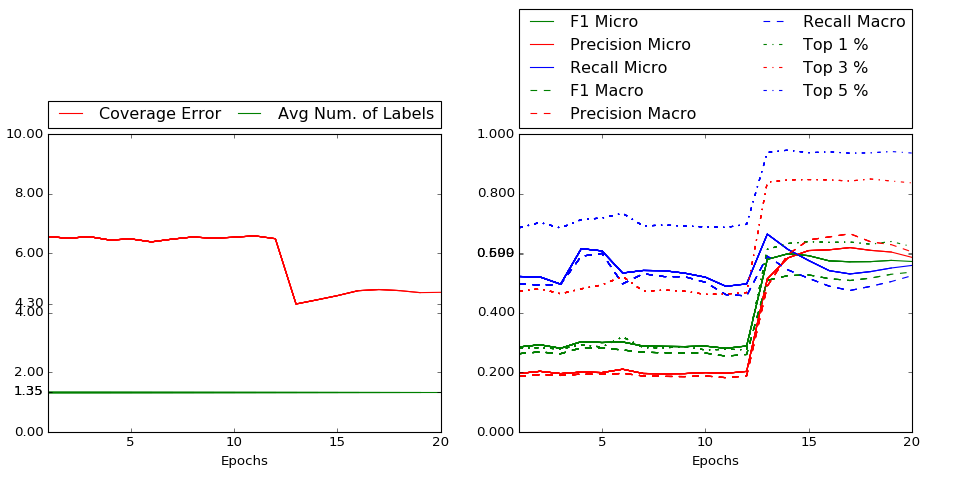

doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}_iter_1000_reg_0.001
Epoch 01: Coverage Error -> 6.56
Epoch 02: Coverage Error -> 6.51
Epoch 03: Coverage Error -> 6.56
Epoch 04: Coverage Error -> 6.45
Epoch 05: Coverage Error -> 6.49
Epoch 06: Coverage Error -> 6.39
Epoch 07: Coverage Error -> 6.48
Epoch 08: Coverage Error -> 6.55
Epoch 09: Coverage Error -> 6.51
Epoch 10: Coverage Error -> 6.54
Epoch 11: Coverage Error -> 6.59
Epoch 12: Coverage Error -> 6.50
Epoch 13: Coverage Error -> 4.30
Epoch 14: Coverage Error -> 4.44
Epoch 15: Coverage Error -> 4.58
Epoch 16: Coverage Error -> 4.75
Epoch 17: Coverage Error -> 4.79
Epoch 18: Coverage Error -> 4.75
Epoch 19: Coverage Error -> 4.68
Epoch 20: Coverage Error -> 4.69


In [32]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()
print placeholder_model_name + "_" + GLOBAL_VARS.SVM_MODEL_NAME

for epoch in range(1,DOC2VEC_MAX_EPOCHS+1):
    try:
        model_name = placeholder_model_name.format(epoch)
        metrics = pickle.load(open(os.path.join(doc2vec_model_save_location, model_name, GLOBAL_VARS.SVM_MODEL_NAME, METRICS)))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break

In [119]:
[metric['coverage_error'] for metric in epoch_metrics]

[6.0518029456576938,
 4.3138649060436771,
 3.7851701371254443,
 1.4565769426104622,
 1.3819197562214323]